# Phase 1: Floorplan Model Training - PyTorch Implementation

This notebook implements a computer vision model to parse floorplan images and extract structured attributes.

## 1. Setup and Imports

In [1]:
# Install required packages
!pip install torch torchvision pycocotools opencv-python albumentations pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import defaultdict, Counter
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Configuration

In [2]:
import json
from collections import Counter

# Paths to annotation files
train_ann_file = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/train/_annotations_clean.coco.json"
val_ann_file   = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/valid/_annotations_clean.coco.json"

def summarize_coco(ann_file):
    with open(ann_file) as f:
        coco = json.load(f)
    
    # List categories
    categories = {cat['id']: cat['name'] for cat in coco['categories']}
    print("Categories:", categories)

    # Total images
    total_images = len(coco['images'])
    print("Total images:", total_images)

    # Count objects per class
    counts = Counter()
    for ann in coco['annotations']:
        counts[ann['category_id']] += 1

    print("Objects per class:")
    for cat_id, count in counts.items():
        print(f"  {categories[cat_id]}: {count}")

    print("-"*50)

print("Train set summary:")
summarize_coco(train_ann_file)

print("Validation set summary:")
summarize_coco(val_ann_file)


Train set summary:
Categories: {1: 'bathroom', 2: 'bedroom', 3: 'garage', 4: 'hall', 5: 'kitchen', 6: 'laundry', 7: 'porch', 8: 'room'}
Total images: 327
Objects per class:
  kitchen: 299
  garage: 262
  hall: 335
  porch: 388
  room: 190
  bedroom: 612
  bathroom: 462
  laundry: 91
--------------------------------------------------
Validation set summary:
Categories: {1: 'bathroom', 2: 'bedroom', 3: 'garage', 4: 'hall', 5: 'kitchen', 6: 'laundry', 7: 'porch', 8: 'room'}
Total images: 109
Objects per class:
  bedroom: 196
  hall: 108
  kitchen: 90
  bathroom: 98
  porch: 108
  room: 35
  laundry: 32
  garage: 75
--------------------------------------------------


In [ ]:
# import json
# import shutil

# # Paths
# train_ann_file = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/train/_annotations.coco.json"
# val_ann_file   = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/valid/_annotations.coco.json"

# # Output cleaned files
# clean_train_file = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/train/_annotations_clean.coco.json"
# clean_val_file   = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/valid/_annotations_clean.coco.json"

# # List of category_ids to remove (object/duplicate categories)
# remove_category_ids = [0, 7]  # 'objects' in your dataset

# def clean_coco_annotations(input_file, output_file, remove_ids):
#     with open(input_file) as f:
#         coco = json.load(f)

#     # Remove unwanted annotations
#     cleaned_annotations = [ann for ann in coco['annotations'] if ann['category_id'] not in remove_ids]

#     # Remove unwanted categories
#     cleaned_categories = [cat for cat in coco['categories'] if cat['id'] not in remove_ids]

#     # Optionally, remove images that now have no annotations
#     annotated_image_ids = set([ann['image_id'] for ann in cleaned_annotations])
#     cleaned_images = [img for img in coco['images'] if img['id'] in annotated_image_ids]

#     # Save cleaned COCO JSON
#     cleaned_coco = {
#         "info": coco.get("info", {}),
#         "licenses": coco.get("licenses", []),
#         "images": cleaned_images,
#         "annotations": cleaned_annotations,
#         "categories": cleaned_categories
#     }

#     with open(output_file, "w") as f:
#         json.dump(cleaned_coco, f, indent=4)

#     print(f"Saved cleaned annotations to {output_file}")
#     print(f"Total images: {len(cleaned_images)}, total annotations: {len(cleaned_annotations)}")
#     print(f"Categories: {[cat['name'] for cat in cleaned_categories]}")

# # Clean train and val
# clean_coco_annotations(train_ann_file, clean_train_file, remove_category_ids)
# clean_coco_annotations(val_ann_file, clean_val_file, remove_category_ids)


Saved cleaned annotations to /home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/train/_annotations_clean.coco.json
Total images: 327, total annotations: 2639
Categories: ['bathroom', 'bedroom', 'garage', 'hall', 'kitchen', 'laundry', 'porch', 'room', 'shop']
Saved cleaned annotations to /home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/valid/_annotations_clean.coco.json
Total images: 109, total annotations: 742
Categories: ['bathroom', 'bedroom', 'garage', 'hall', 'kitchen', 'laundry', 'porch', 'room', 'shop']


In [ ]:
# import json
# clean_train_file = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/train/_annotations_clean.coco.json"
# clean_val_file   = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/valid/_annotations_clean.coco.json"
# def remap_coco_categories(input_file, output_file):
#     # Mapping old IDs -> new IDs
#     id_map = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 8:7, 9:8}
    
#     with open(input_file) as f:
#         coco = json.load(f)
    
#     # Remap annotations
#     for ann in coco['annotations']:
#         if ann['category_id'] in id_map:
#             ann['category_id'] = id_map[ann['category_id']]
#         else:
#             raise ValueError(f"Found unexpected category_id: {ann['category_id']}")

#     # Remap categories
#     for cat in coco['categories']:
#         if cat['id'] in id_map:
#             cat['id'] = id_map[cat['id']]
#         else:
#             print(f"Removing unused category: {cat['name']}")
    
#     # Remove duplicates in categories
#     new_cats = []
#     seen_ids = set()
#     for cat in coco['categories']:
#         if cat['id'] not in seen_ids:
#             new_cats.append(cat)
#             seen_ids.add(cat['id'])
#     coco['categories'] = new_cats

#     # Save cleaned JSON
#     with open(output_file, 'w') as f:
#         json.dump(coco, f, indent=4)
#     print(f"Saved remapped COCO JSON to {output_file}")

# # Example usage
# remap_coco_categories(clean_train_file, clean_train_file)  # overwrite
# remap_coco_categories(clean_val_file, clean_val_file)      # overwrite


Saved remapped COCO JSON to /home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/train/_annotations_clean.coco.json
Saved remapped COCO JSON to /home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/valid/_annotations_clean.coco.json


In [ ]:
# def remap_category_ids(input_file, output_file):
#     with open(input_file) as f:
#         coco = json.load(f)
    
#     # Remap shop (10) -> 9 (last class in CLASSES)
#     for ann in coco['annotations']:
#         if ann['category_id'] == 10:
#             ann['category_id'] = 9

#     # Also update categories list
#     for cat in coco['categories']:
#         if cat['id'] == 10:
#             cat['id'] = 9

#     # Save JSON
#     with open(output_file, 'w') as f:
#         json.dump(coco, f, indent=4)
#     print(f"Saved remapped COCO JSON to {output_file}")

# # Example
# remap_category_ids(clean_train_file, clean_train_file)  # overwrite
# remap_category_ids(clean_val_file, clean_val_file)      # overwrite


Saved remapped COCO JSON to /home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/train/_annotations_clean.coco.json
Saved remapped COCO JSON to /home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/valid/_annotations_clean.coco.json


In [4]:
clean_train_file = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/train/_annotations_clean.coco.json"
clean_val_file   = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/valid/_annotations_clean.coco.json"

In [ ]:
class Config:
    # Paths
    TRAIN_IMG_DIR = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/train"
    VAL_IMG_DIR = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/valid"
    TEST_IMG_DIR = "/home/suruchihardaha/self_working/notebooks/task1/split_data/test"

    # Cleaned annotation files
    TRAIN_ANN_FILE = clean_train_file
    VAL_ANN_FILE   = clean_val_file

    # Model parameters
    NUM_EPOCHS = 20
    BATCH_SIZE = 16
    LEARNING_RATE = 0.005
    WEIGHT_DECAY = 0.0005

    # Classes (after removing 'objects')
    CLASSES = [
        'background',  # 0
        'bathroom',    # 1
        'bedroom',     # 2
        'garage',      # 3
        'hall',        # 4
        'kitchen',     # 5
        'laundry',     # 6
        'porch',       # 7
        'room'         # 8
    ]
    NUM_CLASSES = len(CLASSES)

    # Output paths
    MODEL_SAVE_PATH = "/home/suruchihardaha/self_working/notebooks/task1/floorplan_model_weights.pth"
    RESULTS_DIR = "/home/suruchihardaha/self_working/notebooks/task1/results"

config = Config()


In [6]:
# Optional: Verify that no annotations exceed NUM_CLASSES-1
with open(config.TRAIN_ANN_FILE) as f:
    coco_train = json.load(f)

invalid_labels = [ann['category_id'] for ann in coco_train['annotations'] if ann['category_id'] >= config.NUM_CLASSES]
print("Invalid labels in train set:", invalid_labels)

with open(config.VAL_ANN_FILE) as f:
    coco_val = json.load(f)

invalid_labels_val = [ann['category_id'] for ann in coco_val['annotations'] if ann['category_id'] >= config.NUM_CLASSES]
print("Invalid labels in val set:", invalid_labels_val)


Invalid labels in train set: []
Invalid labels in val set: []


In [7]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(config.NUM_CLASSES)
model.to(device)
print(f"Model created with {config.NUM_CLASSES} classes")


Model created with 9 classes


## 3. Dataset Class for COCO Format

In [11]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import os
import json
from PIL import Image

class FloorplanDataset(Dataset):
    def __init__(self, img_dir, ann_file, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms

        with open(ann_file) as f:
            coco = json.load(f)

        self.images = {img['id']: img for img in coco['images']}
        self.annotations = {}
        for ann in coco['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)
        self.img_ids = list(self.images.keys())

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.images[img_id]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        anns = self.annotations.get(img_id, [])

        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']  # COCO bbox format: [x, y, width, height]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id]),
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target


In [12]:
from torchvision import transforms as T

# Simple transforms
def get_transform(train=True):
    transforms = [T.ToTensor()]
    return T.Compose(transforms)

# Datasets
train_dataset = FloorplanDataset(config.TRAIN_IMG_DIR, config.TRAIN_ANN_FILE, transforms=get_transform(train=True))
val_dataset   = FloorplanDataset(config.VAL_IMG_DIR, config.VAL_ANN_FILE, transforms=get_transform(train=False))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [13]:
import torch.optim as optim
from torchvision.models.detection import FasterRCNN

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=config.LEARNING_RATE, momentum=0.9, weight_decay=config.WEIGHT_DECAY)

# Learning rate scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training function
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch} done, loss: {losses.item():.4f}")


In [14]:
num_epochs = config.NUM_EPOCHS

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

# Save model
torch.save(model.state_dict(), config.MODEL_SAVE_PATH)
print("Model weights saved!")


Epoch 0 done, loss: 0.8977
Epoch 1 done, loss: 1.1110
Epoch 2 done, loss: 1.0274
Epoch 3 done, loss: 0.9063
Epoch 4 done, loss: 0.7133
Epoch 5 done, loss: 0.6259
Epoch 6 done, loss: 0.5526
Epoch 7 done, loss: 0.6804
Epoch 8 done, loss: 0.5048
Epoch 9 done, loss: 0.6835
Epoch 10 done, loss: 0.3860
Epoch 11 done, loss: 0.4154
Epoch 12 done, loss: 0.2609
Epoch 13 done, loss: 0.2600
Epoch 14 done, loss: 0.2808
Epoch 15 done, loss: 0.1844
Epoch 16 done, loss: 0.3335
Epoch 17 done, loss: 0.1781
Epoch 18 done, loss: 0.1582
Epoch 19 done, loss: 0.2054
Epoch 20 done, loss: 0.2132
Epoch 21 done, loss: 0.1051
Epoch 22 done, loss: 0.1781
Epoch 23 done, loss: 0.1547
Epoch 24 done, loss: 0.2382
Epoch 25 done, loss: 0.1716
Epoch 26 done, loss: 0.1466
Epoch 27 done, loss: 0.1030
Epoch 28 done, loss: 0.1415
Epoch 29 done, loss: 0.1177
Epoch 30 done, loss: 0.1566
Epoch 31 done, loss: 0.1901
Epoch 32 done, loss: 0.1621
Epoch 33 done, loss: 0.1773
Epoch 34 done, loss: 0.2219
Epoch 35 done, loss: 0.1682
Ep

In [15]:
import torchvision.transforms.functional as F
from collections import defaultdict

def parse_floorplan(image_path, model, device, threshold=0.5):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)

    outputs = outputs[0]
    boxes = outputs['boxes']
    labels = outputs['labels']
    scores = outputs['scores']

    # Filter by confidence
    boxes = boxes[scores > threshold]
    labels = labels[scores > threshold]

    # Map label index to class name
    id2class = {i: name for i, name in enumerate(config.CLASSES)}
    
    counts = defaultdict(int)
    rooms_detail = defaultdict(int)

    for lbl in labels:
        class_name = id2class[int(lbl)]
        counts[class_name] += 1
        if class_name.lower() in ['bedroom', 'room', 'hall', 'kitchen', 'bathroom']:
            rooms_detail[class_name] += 1

    # Build JSON
    floorplan_json = {
        "rooms": counts.get("room", 0) + counts.get("bedroom", 0),
        "halls": counts.get("hall", 0),
        "kitchens": counts.get("kitchen", 0),
        "bathrooms": counts.get("bathroom", 0),
        "rooms_detail": [{"label": k, "count": v, "approx_area": None} for k, v in rooms_detail.items()]
    }

    return floorplan_json


In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize_inference(image_path, model, device, threshold=0.5):
    model.eval()
    
    # Load and convert image
    img = Image.open(image_path).convert("RGB")
    img_tensor = torchvision.transforms.functional.to_tensor(img).unsqueeze(0).to(device)
    
    # Forward pass
    with torch.no_grad():
        outputs = model(img_tensor)[0]
    
    boxes = outputs['boxes']
    labels = outputs['labels']
    scores = outputs['scores']
    
    # Filter by confidence
    keep = scores > threshold
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]
    
    # Map label index to class name
    id2class = {i: name for i, name in enumerate(config.CLASSES)}
    
    # Plot image
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img)
    
    # Draw boxes
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box.cpu().numpy()
        class_name = id2class[int(label)]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                 edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-5, f"{class_name}: {score:.2f}", color='yellow',
                fontsize=12, backgroundcolor="black")
    
    plt.axis('off')
    plt.show()


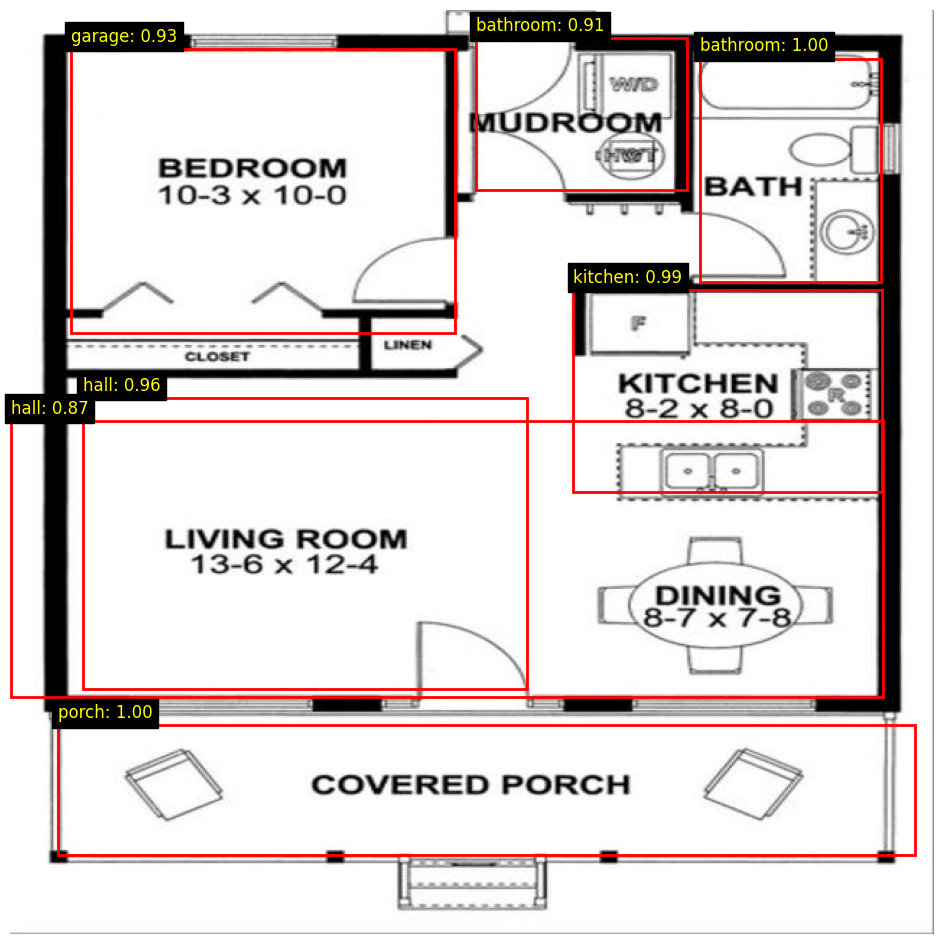

In [17]:
test_image_path = "/home/suruchihardaha/self_working/smastsensedata/assets/images/13_18_jpg.rf.ec11791b4d9cc45c6a4809fd27fd1ca1.jpg"
visualize_inference(test_image_path, model, device, threshold=0.5)


## Since I only annotated tain and val set  , so i only have done evlauation on val set  for which I have hand marked the ground trutuh by myself 

In [18]:
import torch
import torchvision
from torchvision.ops import box_iou
from tqdm import tqdm
import json
import os
from collections import defaultdict
import numpy as np

# Paths
VAL_IMAGES_DIR = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/valid"
VAL_ANN_PATH = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/valid/_annotations_clean.coco.json"
MODEL_PATH = "/home/suruchihardaha/self_working/notebooks/task1/floorplan_model_weights.pth"

# Load validation dataset
from torchvision.datasets import CocoDetection
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
val_dataset = CocoDetection(root=VAL_IMAGES_DIR, annFile=VAL_ANN_PATH, transform=transform)

# Load model
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 9  # 8 + background
model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluation metrics
total_iou = []
class_counts_gt = defaultdict(int)
class_counts_pred = defaultdict(int)
class_correct_counts = defaultdict(int)

iou_threshold = 0.5

for img, targets in tqdm(val_dataset, desc="Evaluating on validation set"):
    img = img.to(device)
    with torch.no_grad():
        preds = model([img])[0]

    pred_boxes = preds['boxes'].cpu()
    pred_labels = preds['labels'].cpu()
    gt_boxes = torch.tensor([obj['bbox'] for obj in targets])
    gt_boxes[:, 2:] += gt_boxes[:, :2]  # convert from xywh to xyxy
    gt_labels = torch.tensor([obj['category_id'] for obj in targets])

    if len(gt_boxes) == 0 or len(pred_boxes) == 0:
        continue

    # Compute IoU
    iou_matrix = box_iou(pred_boxes, gt_boxes)
    iou = iou_matrix.max(dim=1).values
    total_iou.extend(iou.tolist())

    # Count metrics
    for lbl in gt_labels.tolist():
        class_counts_gt[lbl] += 1
    for lbl in pred_labels.tolist():
        class_counts_pred[lbl] += 1

    # Count correctly predicted (IoU > threshold & same label)
    for i, (p_label, iou_val) in enumerate(zip(pred_labels.tolist(), iou.tolist())):
        if iou_val > iou_threshold:
            class_correct_counts[p_label] += 1

# Aggregate metrics
mean_iou = np.mean(total_iou)
print(f"\nMean IoU across all validation boxes: {mean_iou:.4f}\n")

print("Per-class count accuracy:")
for cls_id in sorted(class_counts_gt.keys()):
    gt = class_counts_gt[cls_id]
    pred = class_counts_pred[cls_id]
    correct = class_correct_counts[cls_id]
    acc = correct / gt if gt > 0 else 0
    print(f"Class {cls_id}: GT={gt}, Pred={pred}, Correct={correct}, Accuracy={acc:.2f}")


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Evaluating on validation set: 100%|██████████| 109/109 [00:02<00:00, 36.50it/s]


Mean IoU across all validation boxes: 0.4960

Per-class count accuracy:
Class 1: GT=98, Pred=298, Correct=109, Accuracy=1.11
Class 2: GT=196, Pred=270, Correct=210, Accuracy=1.07
Class 3: GT=75, Pred=160, Correct=109, Accuracy=1.45
Class 4: GT=108, Pred=296, Correct=191, Accuracy=1.77
Class 5: GT=90, Pred=212, Correct=135, Accuracy=1.50
Class 6: GT=32, Pred=140, Correct=66, Accuracy=2.06
Class 7: GT=108, Pred=305, Correct=137, Accuracy=1.27
Class 8: GT=35, Pred=342, Correct=201, Accuracy=5.74


 ### in iou 0.5 it gives many false poisitives so i increased the iou this time : 

In [20]:
import torch
import torchvision
from torchvision.ops import box_iou
from tqdm import tqdm
import json
import os
from collections import defaultdict
import numpy as np

# Paths
VAL_IMAGES_DIR = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/valid"
VAL_ANN_PATH = "/home/suruchihardaha/self_working/notebooks/train-val_dataset_final.coco/valid/_annotations_clean.coco.json"
MODEL_PATH = "/home/suruchihardaha/self_working/notebooks/task1/floorplan_model_weights.pth"

# Load validation dataset
from torchvision.datasets import CocoDetection
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
val_dataset = CocoDetection(root=VAL_IMAGES_DIR, annFile=VAL_ANN_PATH, transform=transform)

# Load model
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 9  # 8 + background
model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluation metrics
total_iou = []
class_counts_gt = defaultdict(int)
class_counts_pred = defaultdict(int)
class_correct_counts = defaultdict(int)

iou_threshold = 0.6

for img, targets in tqdm(val_dataset, desc="Evaluating on validation set"):
    img = img.to(device)
    with torch.no_grad():
        preds = model([img])[0]

    pred_boxes = preds['boxes'].cpu()
    pred_labels = preds['labels'].cpu()
    gt_boxes = torch.tensor([obj['bbox'] for obj in targets])
    gt_boxes[:, 2:] += gt_boxes[:, :2]  # convert from xywh to xyxy
    gt_labels = torch.tensor([obj['category_id'] for obj in targets])

    if len(gt_boxes) == 0 or len(pred_boxes) == 0:
        continue

    # Compute IoU
    iou_matrix = box_iou(pred_boxes, gt_boxes)
    iou = iou_matrix.max(dim=1).values
    total_iou.extend(iou.tolist())

    # Count metrics
    for lbl in gt_labels.tolist():
        class_counts_gt[lbl] += 1
    for lbl in pred_labels.tolist():
        class_counts_pred[lbl] += 1

    # Count correctly predicted (IoU > threshold & same label)
    for i, (p_label, iou_val) in enumerate(zip(pred_labels.tolist(), iou.tolist())):
        if iou_val > iou_threshold:
            class_correct_counts[p_label] += 1

# Aggregate metrics
mean_iou = np.mean(total_iou)
print(f"\nMean IoU across all validation boxes: {mean_iou:.4f}\n")

print("Per-class count accuracy:")
for cls_id in sorted(class_counts_gt.keys()):
    gt = class_counts_gt[cls_id]
    pred = class_counts_pred[cls_id]
    correct = class_correct_counts[cls_id]
    acc = correct / gt if gt > 0 else 0
    print(f"Class {cls_id}: GT={gt}, Pred={pred}, Correct={correct}, Accuracy={acc:.2f}")


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Evaluating on validation set: 100%|██████████| 109/109 [00:03<00:00, 36.22it/s]


Mean IoU across all validation boxes: 0.4960

Per-class count accuracy:
Class 1: GT=98, Pred=298, Correct=86, Accuracy=0.88
Class 2: GT=196, Pred=270, Correct=192, Accuracy=0.98
Class 3: GT=75, Pred=160, Correct=100, Accuracy=1.33
Class 4: GT=108, Pred=296, Correct=156, Accuracy=1.44
Class 5: GT=90, Pred=212, Correct=103, Accuracy=1.14
Class 6: GT=32, Pred=140, Correct=51, Accuracy=1.59
Class 7: GT=108, Pred=305, Correct=119, Accuracy=1.10
Class 8: GT=35, Pred=342, Correct=185, Accuracy=5.29
